<a href="https://colab.research.google.com/github/supuni9622/Test-Google-Colab/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cd /content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV2/TFID

/content/drive/MyDrive/4th Year Research/M3/Test Implementation/Test-Google-Colab/TestV2/TFID


Load libraries we will need

In [2]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.linear_model import SGDClassifier
import logging
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('Lyrical_data_5.csv',encoding='cp1252')
df = df.dropna(how="any").reset_index(drop=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Song_ID     800 non-null    int64 
 1   Song_Title  800 non-null    object
 2   Chorus      800 non-null    object
 3   Emotion     800 non-null    object
dtypes: int64(1), object(3)
memory usage: 25.1+ KB


Category Distribution

In [5]:
len(df['Emotion'].unique())

6

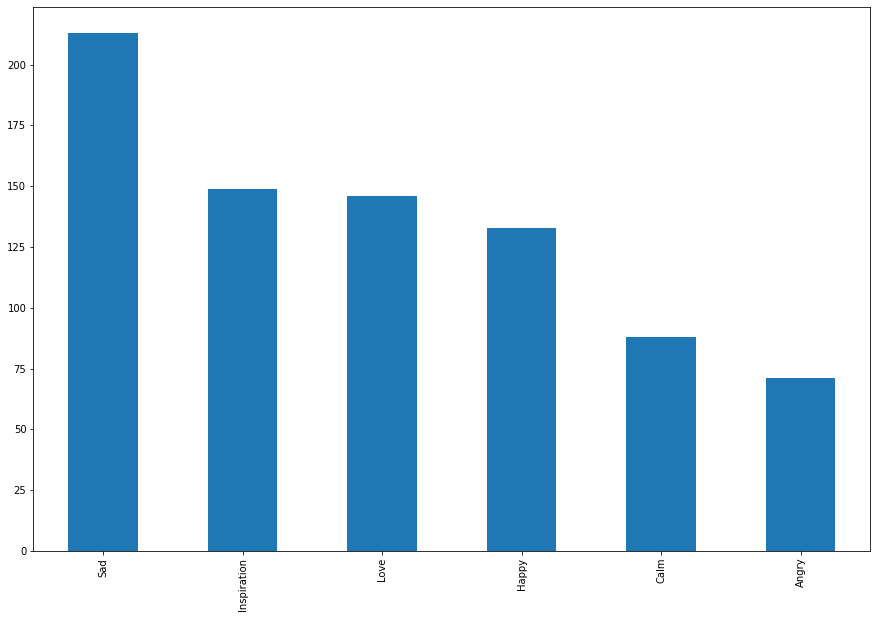

In [6]:
df['Emotion'].value_counts().plot( kind='bar', figsize=(15,10))

Data pre-processing

In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

Function to clean, tokenize, remove stop word, and not alphanumeric from data

In [8]:
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

my_sw = ['make', 'amp',  'news','new' ,'time', 'u','s', 'photos',  'get', 'say']
def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2 and token not in my_sw
  
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text)    
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)

In [9]:
df['Chorus'] = df['Chorus'].apply(clean_txt)

Next we are going to create some news variables columns to try to improve the quaity of our classifier, we will create:
Polarity: to check the sentiment of the text
Subjectivity: to check if text is objective or subjective
The number of word in the text

In [11]:
blob = TextBlob((df.Chorus[0]))
str(blob.correct())

'diana let one light fire inside eye you lonely dont even know feel cry diana let one lift heart save life dont think even realize baby you save mine'

In [12]:
def polarity_txt(text):
  return TextBlob(text).sentiment[0] 

In [13]:
def subj_txt(text):
  return  TextBlob(text).sentiment[1]

In [14]:
def len_text(text):
  if len(text.split())>0:
         return len(set(clean_txt(text).split()))/ len(text.split())
  else:
         return 0

In [15]:
df['polarity'] = df['Chorus'].apply(polarity_txt)
df.head(2)

,Song_ID,Song_Title,Chorus,Emotion,polarity
0,1,Diana,diana let one light fire inside eye youve lone...,Inspiration,0.15
1,2,Don't forget where you belong,dont forget belong home dont forget belong hom...,Inspiration,0.00


In [16]:
df['subjectivity'] = df['Chorus'].apply(subj_txt)
df.head(2)

,Song_ID,Song_Title,Chorus,Emotion,polarity,subjectivity
0,1,Diana,diana let one light fire inside eye youve lone...,Inspiration,0.15,0.7
1,2,Don't forget where you belong,dont forget belong home dont forget belong hom...,Inspiration,0.00,0.0


In [17]:
df['len'] = df['Chorus'].apply(len_text)
df.head(2)

,Song_ID,Song_Title,Chorus,Emotion,polarity,subjectivity,len
0,1,Diana,diana let one light fire inside eye youve lone...,Inspiration,0.15,0.7,0.793103
1,2,Don't forget where you belong,dont forget belong home dont forget belong hom...,Inspiration,0.00,0.0,0.666667


**Make the Custom class for feature union Transformer of sklearn**

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TextStats(BaseEstimator, TransformerMixin):
    """Extract features from each document for DictVectorizer"""

    def fit(self, x, y=None):
        return self

    def transform(self, data):
        return [{'pos':  row['polarity'], 'sub': row['subjectivity'],  'len': row['len']} for _, row in data.iterrows()]

**Make our Custom Pipeline**

In [25]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            # Pipeline for pulling features from the text
            ('Chorus', Pipeline([
                ('selector', ItemSelector(key='Chorus')),
                ('tfidf', TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
                    strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
                    ngram_range=(1, 10), use_idf=1,smooth_idf=1,sublinear_tf=1,
                    stop_words = None, preprocessor=clean_txt)),
            ])),

            # Pipeline for pulling metadata features
            ('stats', Pipeline([
                ('selector', ItemSelector(key=['polarity', 'subjectivity', 'len'])),
                ('stats', TextStats()),  # returns a list of dicts
                ('vect', DictVectorizer()),  # list of dicts -> feature matrix
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'Chorus': 0.9,
            'stats': 1.5,
        },
    ))
])

Build the pipeline

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
seed = 40
X = df[['Chorus', 'polarity', 'subjectivity','len']]
y =df['Emotion']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [27]:
pipeline.fit(x_train)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('Chorus',
                                                 Pipeline(steps=[('selector',
                                                                  ItemSelector(key='Chorus')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.2,
                                                                                  min_df=3,
                                                                                  ngram_range=(1,
                                                                                               10),
                                                                                  preprocessor=<function clean_txt at 0x7ff10d055f80>,
                                                                                  smooth_idf=1,
                                                    

Transform and train the ML models

In [28]:
%%time
train_vec = pipeline.transform(x_train)
test_vec = pipeline.transform(x_test)
print("Checking that the number of features in train and test correspond: %s - %s" % (train_vec.shape, test_vec.shape))

Checking that the number of features in train and test correspond: (640, 1301) - (160, 1301)
CPU times: user 591 ms, sys: 0 ns, total: 591 ms
Wall time: 598 ms


In [29]:
clf_sv = LinearSVC(C=1, class_weight='balanced', multi_class='ovr', random_state=40, max_iter=10000) #Support Vector machines
clf_sgd = SGDClassifier(max_iter=200,) # Stochastic Gradient Classifier

In [32]:
%%time
from sklearn.model_selection import cross_val_score

clfs = [clf_sv, clf_sgd]
cv = 6
for clf in clfs:
    scores = cross_val_score(clf,train_vec, y_train, cv=cv, scoring="accuracy" )
    print (scores)
    print (("Mean score: {0:.3f} (+/-{1:.3f})").format(
        np.mean(scores), np.std(scores)))

[0.5046729  0.47663551 0.57009346 0.46728972 0.41509434 0.47169811]
Mean score: 0.484 (+/-0.047)
[0.41121495 0.44859813 0.5046729  0.42056075 0.36792453 0.44339623]
Mean score: 0.433 (+/-0.042)
CPU times: user 234 ms, sys: 0 ns, total: 234 ms
Wall time: 234 ms


In [33]:
%%time
from sklearn.metrics import classification_report
clf_sv.fit(train_vec, y_train )
y_pred = clf_sv.predict(test_vec)
list_result =[]
list_result.append(("SVC",accuracy_score(y_test, y_pred)))
clf_sgd.fit(train_vec, y_train )
y_pred = clf_sgd.predict(test_vec)
list_result.append(("SGD",accuracy_score(y_test, y_pred)))

CPU times: user 48.6 ms, sys: 823 µs, total: 49.4 ms
Wall time: 51.2 ms


**Deep Learning and Spacy Models**

In [34]:
import spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=cc867099d79fbe12291923a2948cf1c8a5ec3661d67c80d16e6976174a5f95b7
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmw24olj/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [37]:
import en_core_web_lg
nlp = en_core_web_lg.load()

In [43]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Embedding
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.layers import Dense, Input, LSTM, Bidirectional, Activation, Conv1D, GRU, TimeDistributed
from keras.layers import Dropout, Embedding, GlobalMaxPooling1D, MaxPooling1D, Add, Flatten, SpatialDropout1D
from keras.layers import GlobalAveragePooling1D, BatchNormalization, concatenate
from keras.layers import Reshape, merge, Concatenate, Lambda, Average
from keras import backend as K
from keras import initializers, regularizers, constraints

Using TensorFlow backend.

In [45]:
from sklearn.model_selection import train_test_split
import time
X = df['Chorus']
y =df['Emotion']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
Y = np_utils.to_categorical(y)
##Create the tf-idf vector
vectorizer = TfidfVectorizer( min_df =3, max_df=0.2, max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = None, preprocessor=clean_txt)

In [46]:
seed = 40
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed, stratify =y)
vectorizer.fit(x_train)

TfidfVectorizer(max_df=0.2, min_df=3,
                preprocessor=<function clean_txt at 0x7ff10d055f80>,
                smooth_idf=1, strip_accents='unicode', sublinear_tf=1,
                token_pattern='\\w{1,}', use_idf=1)

In [47]:
word2idx = {word: idx for idx, word in enumerate(vectorizer.get_feature_names())}
tokenize = vectorizer.build_tokenizer()
preprocess = vectorizer.build_preprocessor()
 
def to_sequence(tokenizer, preprocessor, index, text):
    words = tokenizer(preprocessor(text))
    indexes = [index[word] for word in words if word in index]
    return indexes

X_train_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_train]
print(X_train_sequences[0])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[80, 297, 214, 5, 844, 614, 671, 702, 131, 614, 760, 608, 165, 493, 215, 607, 766, 764, 749, 305, 180, 760, 215, 608, 760]


In [48]:
# Compute the max lenght of a text

MAX_SEQ_LENGHT=60

N_FEATURES = len(vectorizer.get_feature_names())
X_train_sequences = pad_sequences(X_train_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)
print(X_train_sequences[0])

[859 859 859 859 859 859 859 859 859 859 859 859 859 859 859 859 859 859
 859 859 859 859 859 859 859 859 859 859 859 859 859 859 859 859 859  80
 297 214   5 844 614 671 702 131 614 760 608 165 493 215 607 766 764 749
 305 180 760 215 608 760]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [49]:
X_test_sequences = [to_sequence(tokenize, preprocess, word2idx, x) for x in x_test]
X_test_sequences = pad_sequences(X_test_sequences, maxlen=MAX_SEQ_LENGHT, value=N_FEATURES)

Making the spacy embeding

In [50]:
EMBEDDINGS_LEN = 300

embeddings_index = np.zeros((len(vectorizer.get_feature_names()) + 1, EMBEDDINGS_LEN))
for word, idx in word2idx.items():
    try:
        embedding = nlp.vocab[word].vector
        embeddings_index[idx] = embedding
    except:
        pass
      
print("EMBEDDINGS_LEN=", EMBEDDINGS_LEN)   

EMBEDDINGS_LEN= 300


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Simple LSTM Model

In [51]:
 
model = Sequential()
model.add(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))
model.add(LSTM(300, dropout=0.2))
model.add(Dense(len(set(y)), activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 300)           258000    
                                                                 
 lstm (LSTM)                 (None, 300)               721200    
                                                                 
 dense (Dense)               (None, 6)                 1806      
                                                                 
Total params: 981,006
Trainable params: 723,006
Non-trainable params: 258,000
_________________________________________________________________
None


In [52]:
model.fit(X_train_sequences, y_train, 
          epochs=5, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate(X_test_sequences, y_test, verbose=1)
print("Accuracy:", scores[1])  #
list_result.append(("LSTM Simple", scores[1]))

Epoch 1/5
5/5 [==============================] - 6s 777ms/step - loss: 1.7268 - accuracy: 0.2517 - val_loss: 1.7097 - val_accuracy: 0.2969
Epoch 2/5
5/5 [==============================] - 3s 623ms/step - loss: 1.5379 - accuracy: 0.4184 - val_loss: 1.5860 - val_accuracy: 0.3594
Epoch 3/5
5/5 [==============================] - 3s 616ms/step - loss: 1.3749 - accuracy: 0.5191 - val_loss: 1.6067 - val_accuracy: 0.4219
Epoch 4/5
5/5 [==============================] - 3s 624ms/step - loss: 1.2106 - accuracy: 0.5417 - val_loss: 1.7025 - val_accuracy: 0.4531
Epoch 5/5
5/5 [==============================] - 1s 91ms/step - loss: 1.5389 - accuracy: 0.3875
Accuracy: 0.38749998807907104


In [53]:
len(x_train.keys())

640

Model LSTM and concatenate new columns

In [54]:
from keras.models import Model
from keras.layers import Dense ,LSTM,concatenate,Input,Flatten,BatchNormalization, GRU

text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((LSTM(300, dropout=0.2, recurrent_dropout=0.2)))(x)
x4 = concatenate([x2, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data ], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 60)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 60, 300)      258000      ['text[0][0]']                   
                                                                                                  
 lstm_1 (LSTM)                  (None, 300)          721200      ['embedding_1[0][0]']            
                                                                                                  
 meta (InputLayer)              [(None, 3)]          0           []                               
                                                                                              

In [56]:
df_cat_train = df.iloc[x_train.index][['polarity', 'subjectivity', 'len']]
df_cat_test = df.iloc[x_test.index][['polarity', 'subjectivity', 'len']]

In [57]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=12, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  
list_result.append(("LSTM with Multi-Input", scores[1]))

Epoch 1/12
5/5 [==============================] - 10s 1s/step - loss: 2.0072 - accuracy: 0.2188 - val_loss: 1.7584 - val_accuracy: 0.2188
Epoch 2/12
5/5 [==============================] - 6s 1s/step - loss: 1.5092 - accuracy: 0.3924 - val_loss: 1.7276 - val_accuracy: 0.3125
Epoch 3/12
5/5 [==============================] - 6s 1s/step - loss: 1.2878 - accuracy: 0.5087 - val_loss: 1.7024 - val_accuracy: 0.3281
Epoch 4/12
5/5 [==============================] - 6s 1s/step - loss: 1.1191 - accuracy: 0.5781 - val_loss: 1.6706 - val_accuracy: 0.3594
Epoch 5/12
5/5 [==============================] - 6s 1s/step - loss: 0.9466 - accuracy: 0.6615 - val_loss: 1.6559 - val_accuracy: 0.3906
Epoch 6/12
5/5 [==============================] - 6s 1s/step - loss: 0.8140 - accuracy: 0.6979 - val_loss: 1.6699 - val_accuracy: 0.3594
Epoch 7/12
5/5 [==============================] - 6s 1s/step - loss: 0.7384 - accuracy: 0.7517 - val_loss: 1.6374 - val_accuracy: 0.3906
Epoch 8/12
5/5 [========================

Model with 2 GRU (Bi-GRU)

In [58]:
text_data = Input(shape=(MAX_SEQ_LENGHT,), name='text')
meta_data = Input(shape=(3,), name = 'meta')
x=(Embedding(len(vectorizer.get_feature_names()) + 1,
                    EMBEDDINGS_LEN,  # Embedding size
                    weights=[embeddings_index],
                    input_length=MAX_SEQ_LENGHT,
                    trainable=False))(text_data)
x2 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2,  return_sequences=True)))(x)
x3 = ((GRU(128, dropout=0.2, recurrent_dropout=0.2)))(x2)
x4 = concatenate([x3, meta_data])
x5 = Dense(150, activation='relu')(x4)
x6 = Dropout(0.25)(x5)
x7 = BatchNormalization()(x6)
out=(Dense(len(set(y)), activation="softmax"))(x7)
model = Model(inputs=[text_data, meta_data], outputs=out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None, 60)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 60, 300)      258000      ['text[0][0]']                   
                                                                                                  
 gru (GRU)                      (None, 60, 128)      165120      ['embedding_2[0][0]']            
                                                                                                  
 gru_1 (GRU)                    (None, 128)          99072       ['gru[0][0]']                    
                                                                                            

In [59]:
model.fit([X_train_sequences, df_cat_train], y_train, 
          epochs=20, batch_size=128, verbose=1, 
          validation_split=0.1)
 
scores = model.evaluate([X_test_sequences, df_cat_test],y_test, verbose=1)
print("Accuracy:", scores[1])  # 
list_result.append(("Bi-GRU", scores[1]))

Epoch 1/20
5/5 [==============================] - 10s 839ms/step - loss: 2.1754 - accuracy: 0.1910 - val_loss: 1.7468 - val_accuracy: 0.2188
Epoch 2/20
5/5 [==============================] - 3s 651ms/step - loss: 1.7425 - accuracy: 0.3003 - val_loss: 1.7120 - val_accuracy: 0.3125
Epoch 3/20
5/5 [==============================] - 3s 646ms/step - loss: 1.6408 - accuracy: 0.3455 - val_loss: 1.6933 - val_accuracy: 0.3125
Epoch 4/20
5/5 [==============================] - 3s 644ms/step - loss: 1.4867 - accuracy: 0.4201 - val_loss: 1.6778 - val_accuracy: 0.3125
Epoch 5/20
5/5 [==============================] - 3s 652ms/step - loss: 1.3890 - accuracy: 0.4549 - val_loss: 1.6626 - val_accuracy: 0.3594
Epoch 6/20
5/5 [==============================] - 3s 649ms/step - loss: 1.2796 - accuracy: 0.5104 - val_loss: 1.6607 - val_accuracy: 0.3594
Epoch 7/20
5/5 [==============================] - 3s 648ms/step - loss: 1.1510 - accuracy: 0.5642 - val_loss: 1.6565 - val_accuracy: 0.3594
Epoch 8/20
5/5 [===

Models Comparison

In [61]:
pd.DataFrame(list_result, columns=['model', 'accuracy'])

,model,accuracy
0,SVC,0.45625
1,SGD,0.45625
2,LSTM Simple,0.38750
3,LSTM with Multi-Input,0.43125
4,Bi-GRU,0.38750


[A Basic NLP Tutorial for News Multiclass Categorization](https://github.com/ArmandDS/news_category/blob/master/News_Analysis_AO.ipynb)

[A Basic NLP Tutorial for News Multiclass Categorization](https://medium.com/@armandj.olivares/a-basic-nlp-tutorial-for-news-multiclass-categorization-82afa6d46aa5)